https://github.com/Amir-Hofo

--------

# 00_Arguments

In [2]:
system= "colab"
grid_search= True
seed= False

wandb_enable= False
if wandb_enable:
  wandb_arg_name= input('Please input the WandB argument name:')

batch_size= None
seq_len= None

embedding_dim= None
num_layers= None
hidden_dim= None
weight_drop= None

lr= None
wd= None
momentum= None
clip= None

-----------

# 01_Library

## insatll

In [3]:
# try:
#     import torchtext
# except ImportError:
#     ! pip install -q torchtext==0.17.0
#     import torchtext
# ! pip install -q torchmetrics tqdm wandb

## import

In [51]:
import os
from glob import glob
import urllib.request
import zipfile
from collections import Counter
import random

# import torchmetrics as tm
# import wandb
# import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Dataset, random_split

import torchvision
from torchvision import transforms

from PIL import Image
import cv2

In [5]:
! python --version
for lib in [torch, torchvision]:
  print(lib.__name__, '-->', lib.__version__)

Python 3.11.11
torch --> 2.6.0+cu124
torchvision --> 0.21.0+cu124


-------

# 02_Utils

## system

In [6]:
if system== "local":
    project_path= r"./"
    dataset_path= './dataset/'

elif system== "colab":
    root_path= '/content/'
    project_path= r"/content/drive/MyDrive/Catalist/3_medical image segmentation/"
    dataset_path= os.path.join(project_path, r'dataset/')

else:
  raise ValueError("Invalid system")

## device

In [7]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## drive mount

In [8]:
if system== "colab":
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


## number of params fn

In [9]:
def num_trainable_params(model):
  nums= sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

## avragemeter

In [10]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## set seed

In [11]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)

--------------

# 03_Data

## 3_1. download dataset

In [12]:
data_link= "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/27923/3495119/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1742638734&Signature=Jftz4DZ5iMb7ThmX3iIemrInJhU7HaMXGD4MuoAEzJ3H12MJcq3EBWwHqKP7zJH8%2FQJWcsIcJXdqu2nBOd37Kik4RvSwZenZiyroXI5oT0gTBhk5adhkYL4HSWsAV0fA0vP6QFfF%2B8LeamDNzVid%2FE4PE6hOyCvnZF3lOT60KeXZJ6BHvC5onKKagD4St8en2RAcIArb7RMaQGk%2FFkAhkZ2LcRH2I8T8C3NyoLKTmnAMDQqvLtLhJzHGNxtmt%2BzoaeOjO%2BJxPLpdCRCORa22ZFkDj6cdSRWviD4QnF8eVqzHkXN5XmrcTPpt2mDrbv96Dm%2B4GdrYcOh4Jjesl7pc4g%3D%3D&response-content-disposition=attachment%3B+filename%3Duw-madison-gi-tract-image-segmentation.zip"

files = {"dataset.zip": data_link}

for filename, url in files.items():
  if not os.path.exists(os.path.join(dataset_path, filename)):
    urllib.request.urlretrieve(url, os.path.join(dataset_path, filename))
    print(f"{filename} has been downloaded.")
  else:
    print(f"{filename} already exists.")

dataset.zip already exists.


In [13]:
data_path= os.path.join(root_path, "dataset/")
os.makedirs(data_path, exist_ok= True)
for file in files:
    with zipfile.ZipFile(os.path.join(dataset_path, file), 'r') as zip_ref:
        zip_ref.extractall(data_path)
    print(f"{file} extraction is complete.")

dataset.zip extraction is complete.


----------

## 3_2. preprocess

### load csv file

In [22]:
df= pd.read_csv(os.path.join(data_path, 'train.csv'))
df.dropna(inplace= True)
display(df.head())
df.shape

,id,class,segmentation
194,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...
197,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...
200,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...
203,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...
206,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...


(33913, 3)

### pivot table

In [23]:
df= df.pivot_table(index= 'id', columns= 'class', values= 'segmentation', aggfunc= 'first')
df.reset_index(inplace= True)
df.fillna('', inplace= True)
display(df.head())
df.shape

class,id,large_bowel,small_bowel,stomach
0,case101_day20_slice_0066,,,32107 5 32371 10 32635 13 32900 15 33165 17 33...
1,case101_day20_slice_0067,,,31313 2 31577 7 31841 10 32105 14 32369 17 326...
2,case101_day20_slice_0068,,,30517 2 30781 6 31046 9 31311 11 31575 15 3184...
3,case101_day20_slice_0069,,,29981 10 30246 13 30511 16 30776 19 31041 21 3...
4,case101_day20_slice_0070,,,28918 9 29182 14 29446 18 29711 21 29976 23 30...


(16590, 4)

### image pathes

In [27]:
image_path_list= glob(os.path.join(data_path, 'train', '**', '*.png'), recursive= True)

id_list= []
for i in range(0, len(image_path_list)):
  components= image_path_list[i].split(os.path.sep)[-3::2]
  id_list.append('_'.join([components[0], components[1]]).rsplit('_', 4)[0])

df_path= pd.DataFrame()
df_path['id'], df_path['path']= id_list, image_path_list
display(df_path.head())
df_path.shape

,id,path
0,case29_day0_slice_0119,/content/dataset/train/case29/case29_day0/scan...
1,case29_day0_slice_0038,/content/dataset/train/case29/case29_day0/scan...
2,case29_day0_slice_0035,/content/dataset/train/case29/case29_day0/scan...
3,case29_day0_slice_0118,/content/dataset/train/case29/case29_day0/scan...
4,case29_day0_slice_0075,/content/dataset/train/case29/case29_day0/scan...


(38496, 2)

### merge paths with df

In [28]:
df= df.merge(df_path, on= 'id')
df.head()

,id,large_bowel,small_bowel,stomach,path
0,case101_day20_slice_0066,,,32107 5 32371 10 32635 13 32900 15 33165 17 33...,/content/dataset/train/case101/case101_day20/s...
1,case101_day20_slice_0067,,,31313 2 31577 7 31841 10 32105 14 32369 17 326...,/content/dataset/train/case101/case101_day20/s...
2,case101_day20_slice_0068,,,30517 2 30781 6 31046 9 31311 11 31575 15 3184...,/content/dataset/train/case101/case101_day20/s...
3,case101_day20_slice_0069,,,29981 10 30246 13 30511 16 30776 19 31041 21 3...,/content/dataset/train/case101/case101_day20/s...
4,case101_day20_slice_0070,,,28918 9 29182 14 29446 18 29711 21 29976 23 30...,/content/dataset/train/case101/case101_day20/s...


In [29]:
df['case']= df['id'].apply(lambda x: x.split('_')[0].replace('case', ''))
df['day']= df['id'].apply(lambda x: int(x.split('_')[1].replace('day', '')))
df['slice']= df['id'].apply(lambda x: x.split('_')[3])
df['width']= df['path'].apply(lambda x: int(x[:-4].rsplit("_", 4)[1]))
df['height']= df['path'].apply(lambda x: int(x[:-4].rsplit("_", 4)[2]))
df['counts']= np.sum(df.iloc[:, 1:4] != '', axis= 1).values

display(df.head())
df['counts'].unique()

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,counts
0,case101_day20_slice_0066,,,32107 5 32371 10 32635 13 32900 15 33165 17 33...,/content/dataset/train/case101/case101_day20/s...,101,20,0066,266,266,1
1,case101_day20_slice_0067,,,31313 2 31577 7 31841 10 32105 14 32369 17 326...,/content/dataset/train/case101/case101_day20/s...,101,20,0067,266,266,1
2,case101_day20_slice_0068,,,30517 2 30781 6 31046 9 31311 11 31575 15 3184...,/content/dataset/train/case101/case101_day20/s...,101,20,0068,266,266,1
3,case101_day20_slice_0069,,,29981 10 30246 13 30511 16 30776 19 31041 21 3...,/content/dataset/train/case101/case101_day20/s...,101,20,0069,266,266,1
4,case101_day20_slice_0070,,,28918 9 29182 14 29446 18 29711 21 29976 23 30...,/content/dataset/train/case101/case101_day20/s...,101,20,0070,266,266,1


array([1, 2, 3])

### create train, valid and test subset

In [32]:
print(dataset_path)

/content/drive/MyDrive/Catalist/3_medical image segmentation/dataset/


In [33]:
train_cases= open(os.path.join(dataset_path, 'train.txt')).read().replace('case', '').split('\n')
valid_cases= open(os.path.join(dataset_path, 'validation.txt')).read().replace('case', '').split('\n')
test_cases= open(os.path.join(dataset_path, 'test.txt')).read().replace('case', '').split('\n')

In [34]:
df_train= df[df['case'].isin(train_cases)]
df_valid= df[df['case'].isin(valid_cases)]
df_test= df[df['case'].isin(test_cases)]

display(df_train.head())
df_train.shape

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,counts
0,case101_day20_slice_0066,,,32107 5 32371 10 32635 13 32900 15 33165 17 33...,/content/dataset/train/case101/case101_day20/s...,101,20,0066,266,266,1
1,case101_day20_slice_0067,,,31313 2 31577 7 31841 10 32105 14 32369 17 326...,/content/dataset/train/case101/case101_day20/s...,101,20,0067,266,266,1
2,case101_day20_slice_0068,,,30517 2 30781 6 31046 9 31311 11 31575 15 3184...,/content/dataset/train/case101/case101_day20/s...,101,20,0068,266,266,1
3,case101_day20_slice_0069,,,29981 10 30246 13 30511 16 30776 19 31041 21 3...,/content/dataset/train/case101/case101_day20/s...,101,20,0069,266,266,1
4,case101_day20_slice_0070,,,28918 9 29182 14 29446 18 29711 21 29976 23 30...,/content/dataset/train/case101/case101_day20/s...,101,20,0070,266,266,1


(12030, 11)

In [35]:
df_train.to_csv(os.path.join(root_path, 'train-subset.csv'), index= False)
df_valid.to_csv(os.path.join(root_path, 'valid-subset.csv'), index= False)
df_test.to_csv(os.path.join(root_path, 'test-subset.csv'), index= False)

------------

## 3_3. EDA

In [37]:
df_train= pd.read_csv(f'{root_path}train-subset.csv')

### show random sample

In [38]:
def rle_decode(img_size, segments):
  mask= torch.zeros(3, img_size[0] * img_size[1], dtype= torch.float32)
  for i, segment in enumerate(segments):
    if str(segment) != 'nan':
      segment= segment.split()
      starts= np.array(segment[::2], dtype= np.int32) - 1
      ends= starts + np.array(segment[1::2], dtype= np.int32)
      for s, e in zip(starts, ends):
        mask[i, s:e]= 1
  return mask.reshape((3, img_size[0], img_size[1]))

In [43]:
image_transform= transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor(),
                                     transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min())),
                                     transforms.Lambda(lambda x: x.repeat(3, 1, 1))])

mask_transform= transforms.Compose([transforms.Resize((224, 224))])

red: large_bowel, green: small_bowel, blue: stomach


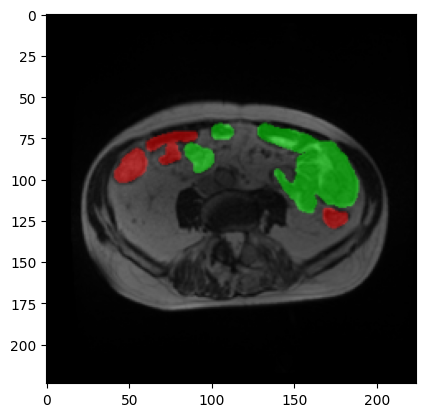

In [47]:
item= random.randint(0, df_train.shape[0])
sample= df_train.iloc[item]

img= Image.open(sample['path'])
mask= rle_decode(img.size[::-1], sample[['large_bowel', 'small_bowel', 'stomach']])

img= image_transform(img)
mask= mask_transform(mask)

plt.imshow(img.permute(1, 2, 0), cmap= 'gray')
plt.imshow(mask.permute(1, 2, 0), alpha= 0.5)
print('red: large_bowel, green: small_bowel, blue: stomach');

### size of images histogram

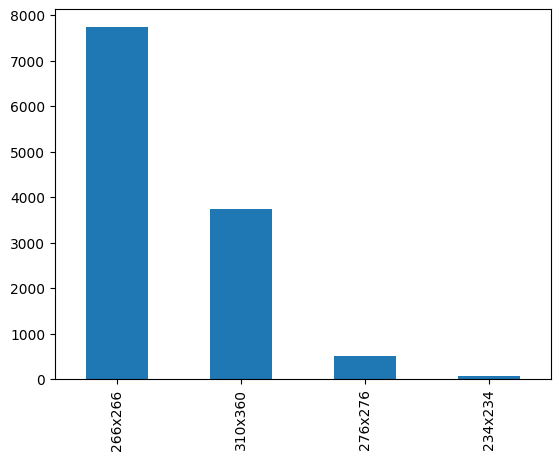

In [49]:
img_sizes= df_train['height'].apply(lambda x: str(x)) + 'x' + df_train['width'].apply(lambda x: str(x))
img_sizes.value_counts().plot(kind= 'bar');

### RAM consumption

In [55]:
total_nbytes= 0
for path in df_train['path']:
  img= cv2.imread(path)
  total_nbytes += img.nbytes
print(f'{total_nbytes/1e6:,.0f} Mb')

3,016 Mb


------------

# 04_Costum Dataset